In [ ]:
# # 1. Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')


In [54]:

# 2. Install required packages
!pip install torch pydeck h5py pandas numpy scikit-learn -q matplotlib ipywidgets tables tqdm seaborn

In [55]:


# 3. Create directories for outputs
import os

DRIVE_OUTPUT_PATH = r'D:\IPYNB Notebooks\dlp_ese\output'
# NEW: A dedicated folder for all tuning runs
DRIVE_TUNING_PATH = os.path.join(DRIVE_OUTPUT_PATH, 'tuning_results')
SCALER_SAVE_PATH = os.path.join(DRIVE_OUTPUT_PATH, 'scaler.pkl')

if not os.path.exists(DRIVE_OUTPUT_PATH):
    os.makedirs(DRIVE_OUTPUT_PATH)
if not os.path.exists(DRIVE_TUNING_PATH):
    os.makedirs(DRIVE_TUNING_PATH)

print(f"Output directory: {DRIVE_OUTPUT_PATH}")
print(f"Tuning results will be saved in: {DRIVE_TUNING_PATH}")

Output directory: D:\IPYNB Notebooks\dlp_ese\output
Tuning results will be saved in: D:\IPYNB Notebooks\dlp_ese\output\tuning_results


In [56]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


PyTorch version: 2.5.1
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4070 Laptop GPU


In [57]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pydeck as pdk
import inspect
import json
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Global Configuration ---
HISTORY_LEN = 12
HORIZON = 12
SEED = 42

# --- File Paths ---
DRIVE_DATA_PATH = r'D:\IPYNB Notebooks\dlp_ese\Dataset_DP_ESE' # <-- IMPORTANT: Update if your path is different
H5_FILE = os.path.join(DRIVE_DATA_PATH, 'metr-la.h5')
ADJ_FILE = os.path.join(DRIVE_DATA_PATH, 'adj_mx.pkl')
LOCATIONS_FILE = os.path.join(DRIVE_DATA_PATH, 'graph_sensor_locations.csv')

# --- Visualization Configuration ---
MAPBOX_API_KEY = "pk.eyJ1IjoicGFydGh1YmhlIiwiYSI6ImNtZmp6bGlsNjEwMXMyanNhdjU0YmZtamsifQ.vD1YKgPOzpX_DMaqIbbpLQ"

# --- Setup Device and Seed ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

print(f"Using device: {device}")

Using device: cuda


In [58]:
# --- Load Files ---
try:
    df_traffic = pd.read_hdf(H5_FILE)
    with open(ADJ_FILE, 'rb') as f:
        sensor_ids_list, sensor_id_map, adj_matrix = pickle.load(f, encoding='latin1')
    df_locations = pd.read_csv(LOCATIONS_FILE)
except FileNotFoundError as e:
    print(f"ERROR: File not found at '{e.filename}'. Please verify your DRIVE_DATA_PATH.")
    raise e

# --- Align and Normalize Data ---
def normalize_adj(adj):
    adj = adj + np.eye(adj.shape[0])
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    return (d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt).astype(np.float32)

adj_norm = torch.tensor(normalize_adj(adj_matrix), device=device)
traffic_values = df_traffic.values

# Align sensor locations (same as before)
df_locations.rename(columns={'sensor_id': 'node_id'}, inplace=True)
df_locations['node_id'] = df_locations['node_id'].astype(str)
sensor_map_df = pd.DataFrame({'sensor_ids': sensor_ids_list, 'node_id': list(sensor_id_map.keys())})
df_locations = pd.merge(df_locations, sensor_map_df, on='node_id', how='right').sort_values(by='sensor_ids').reset_index(drop=True)

# --- Create Datasets and DataLoaders ---
train_size = int(len(traffic_values) * 0.7)
val_size = int(len(traffic_values) * 0.1)
train_data, val_data, test_data = traffic_values[:train_size], traffic_values[train_size:train_size + val_size], traffic_values[train_size + val_size:]

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

def create_dataset(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback:i + lookback + horizon])
    X = np.array(X)[..., np.newaxis]
    y = np.transpose(np.array(y), (0, 2, 1))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = create_dataset(train_data_scaled, HISTORY_LEN, HORIZON)
X_val, y_val = create_dataset(val_data_scaled, HISTORY_LEN, HORIZON)
X_test, y_test = create_dataset(test_data_scaled, HISTORY_LEN, HORIZON)

class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TrafficDataset(X_train, y_train)
val_dataset = TrafficDataset(X_val, y_val)
test_dataset = TrafficDataset(X_test, y_test)

print(f"Data loaded and processed. Train samples: {len(train_dataset)}")

Data loaded and processed. Train samples: 23967


=== 1. Analysis of Train, Validation, and Test Sets ===


--- 1.1 Training Set ---
Info (Structure and Memory):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23990 entries, 0 to 23989
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 37.9 MB

Head (First 5 Rows):


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000



Describe (Statistical Summary):


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
count,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,...,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000
mean,57.061794,60.932824,61.176556,50.061579,47.008567,52.006649,55.272628,56.865381,56.530177,53.469050,...,38.331863,58.882876,51.116157,60.251110,59.094880,56.734678,62.939158,55.314459,59.673987,52.138578
std,20.063672,14.978568,17.476050,15.115344,18.482969,16.164937,17.168220,19.187288,17.432017,22.905283,...,13.026768,19.816564,22.408949,15.152417,20.096318,18.567695,15.992347,15.508219,18.150947,20.365212
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61.750000,63.111111,65.444444,50.555556,35.375000,50.125000,56.555556,60.857143,58.125000,51.750000,...,31.578571,64.333333,53.606250,61.750000,63.500000,60.125000,65.875000,50.875000,63.142857,55.500000
50%,65.125000,65.000000,67.333333,54.000000,46.444444,56.666667,62.333333,63.250000,62.375000,66.000000,...,43.142857,67.111111,61.777778,64.875000,66.750000,63.000000,67.625000,61.375000,66.222222,62.125000
75%,66.888889,66.333333,68.375000,58.125000,64.625000,61.250000,65.111111,65.000000,65.000000,67.666667,...,46.666667,68.428571,64.333333,66.500000,68.250000,64.750000,68.555556,64.555556,67.750000,63.444444
max,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,...,65.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000




--- 1.2 Validation Set ---
Info (Structure and Memory):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3427 entries, 0 to 3426
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 5.4 MB

Head (First 5 Rows):


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,67.750000,65.500000,35.125000,50.750000,32.625000,53.375000,66.500000,61.375000,57.500000,10.875000,...,44.000000,67.250000,63.625000,65.500000,68.750000,63.875000,68.625000,35.125000,64.750000,53.875000
1,68.777778,65.111111,26.555556,35.888889,32.333333,50.888889,62.333333,64.666667,43.777778,9.125000,...,44.111111,68.333333,63.666667,66.666667,67.111111,65.666667,66.777778,26.888889,66.333333,56.555556
2,68.125000,63.000000,23.250000,28.250000,35.000000,28.000000,64.500000,61.500000,45.000000,11.857143,...,40.000000,66.125000,60.750000,66.500000,66.500000,64.625000,67.250000,21.375000,67.285714,61.250000
3,67.625000,65.000000,17.250000,31.125000,37.875000,22.125000,64.500000,63.250000,42.875000,10.625000,...,33.625000,67.250000,60.750000,67.375000,68.875000,65.250000,67.375000,24.250000,67.375000,62.000000
4,68.875000,63.750000,20.125000,36.750000,41.500000,25.750000,63.500000,60.000000,49.200000,9.500000,...,37.428571,69.000000,60.875000,64.875000,68.000000,66.250000,67.375000,21.857143,47.250000,64.375000




--- 1.3 Test Set ---
Info (Structure and Memory):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6855 entries, 0 to 6854
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 10.8 MB

Head (First 5 Rows):


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.750000,56.375000,69.375000,58.000000,66.000000,44.375000,63.125000,52.250000,65.750000,68.000000,...,41.625000,63.000000,55.500000,54.666667,62.750000,63.750000,67.750000,65.750,65.625000,63.500000
1,64.250000,58.500000,68.750000,62.750000,66.500000,54.125000,65.250000,58.500000,64.500000,67.250000,...,42.250000,68.625000,58.125000,55.285714,60.875000,55.625000,65.750000,64.375,65.250000,63.500000
2,62.222222,53.888889,61.888889,61.666667,64.444444,52.444444,63.222222,59.222222,59.888889,68.333333,...,44.333333,64.111111,54.666667,65.000000,60.888889,62.777778,63.888889,63.000,65.777778,63.888889
3,62.250000,54.625000,68.000000,59.250000,65.000000,49.750000,62.750000,58.500000,65.875000,66.750000,...,42.750000,67.500000,59.000000,56.250000,61.750000,58.750000,63.500000,65.250,64.375000,63.875000
4,62.777778,65.444444,64.444444,58.555556,66.777778,50.333333,66.666667,58.666667,60.000000,67.555556,...,44.666667,66.000000,58.222222,66.888889,64.777778,60.111111,62.777778,64.000,66.333333,65.000000




=== 2. Visualization of the Adjacency Matrix      ===


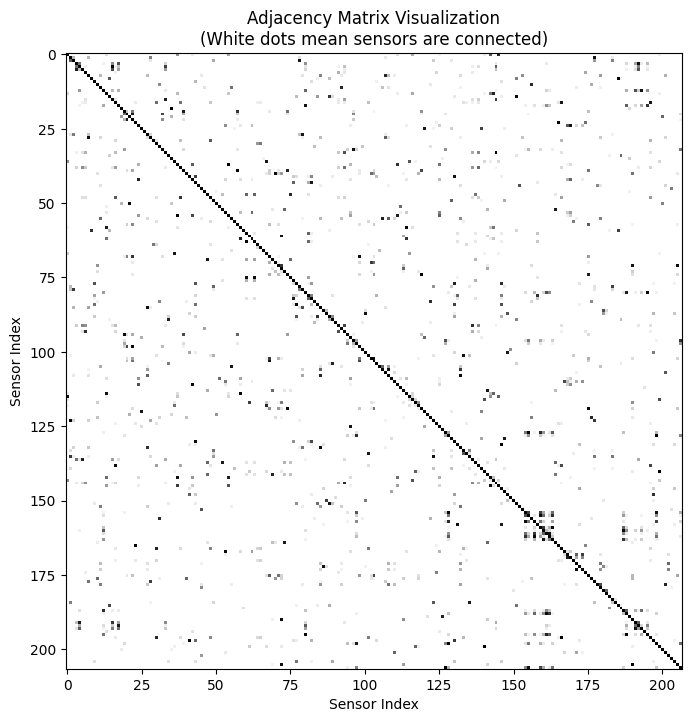



=== 3. Visualization of Normalized Speed Data     ===


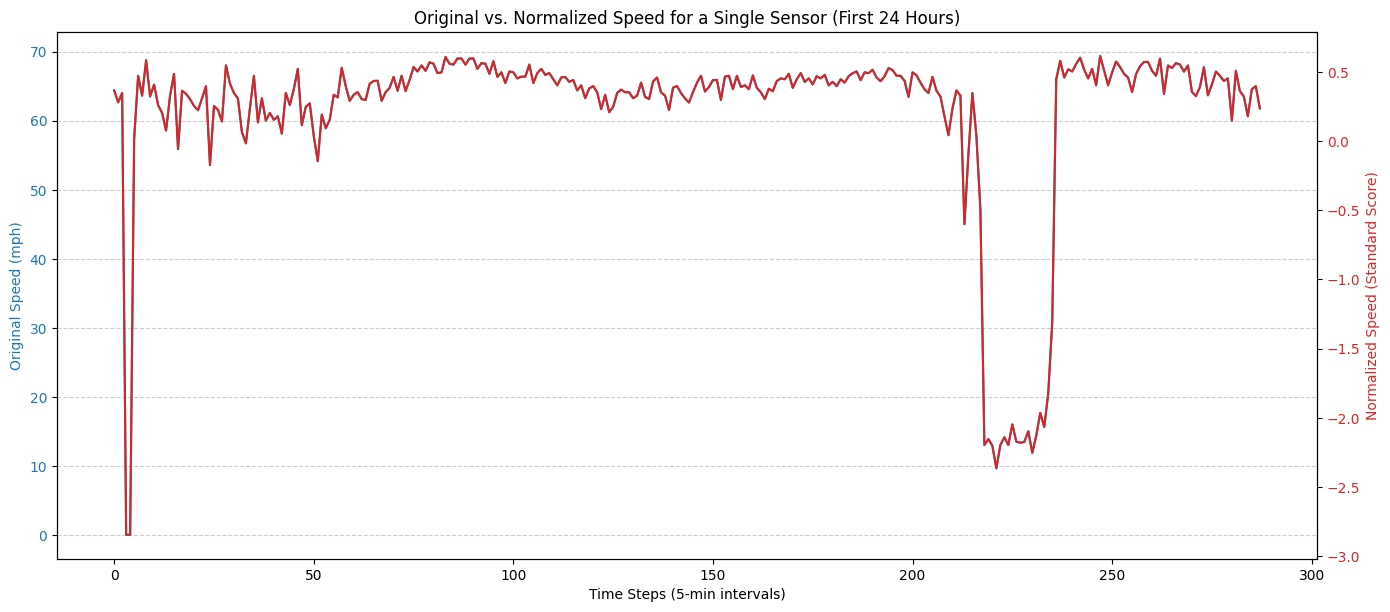

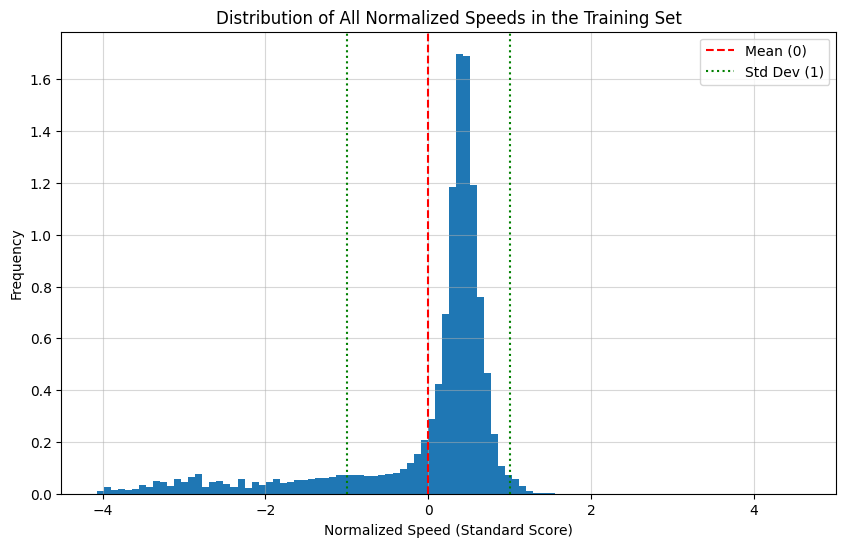

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("======================================================")
print("=== 1. Analysis of Train, Validation, and Test Sets ===")
print("======================================================")

# To use pandas .info(), .head(), and .describe(), we'll temporarily convert
# the numpy arrays back into DataFrames.

# Create DataFrames from the split data
train_df = pd.DataFrame(train_data, columns=df_traffic.columns)
val_df = pd.DataFrame(val_data, columns=df_traffic.columns)
test_df = pd.DataFrame(test_data, columns=df_traffic.columns)

# --- Train Set Analysis ---
print("\n\n--- 1.1 Training Set ---")
print("Info (Structure and Memory):")
train_df.info()
print("\nHead (First 5 Rows):")
display(train_df.head())
print("\nDescribe (Statistical Summary):")
display(train_df.describe())

# --- Validation Set Analysis ---
print("\n\n--- 1.2 Validation Set ---")
print("Info (Structure and Memory):")
val_df.info()
print("\nHead (First 5 Rows):")
display(val_df.head())

# --- Test Set Analysis ---
print("\n\n--- 1.3 Test Set ---")
print("Info (Structure and Memory):")
test_df.info()
print("\nHead (First 5 Rows):")
display(test_df.head())


print("\n\n=======================================================")
print("=== 2. Visualization of the Adjacency Matrix      ===")
print("=======================================================")

# The adj_matrix is a NumPy array, perfect for plotting with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(adj_matrix, cmap='Greys', interpolation='nearest')
plt.title('Adjacency Matrix Visualization\n(White dots mean sensors are connected)')
plt.xlabel('Sensor Index')
plt.ylabel('Sensor Index')
plt.show()


print("\n\n=======================================================")
print("=== 3. Visualization of Normalized Speed Data     ===")
print("=======================================================")

# --- 3.1: Time Series Plot (Original vs. Normalized) ---
# We'll look at the first 24 hours (288 steps) of the first sensor
sensor_index_to_plot = 0
time_steps_to_plot = 288

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the original data on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Time Steps (5-min intervals)')
ax1.set_ylabel('Original Speed (mph)', color=color)
ax1.plot(train_data[:time_steps_to_plot, sensor_index_to_plot], color=color, label='Original')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Normalized Speed (Standard Score)', color=color)
ax2.plot(train_data_scaled[:time_steps_to_plot, sensor_index_to_plot], color=color, label='Normalized')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Original vs. Normalized Speed for a Single Sensor (First 24 Hours)')
plt.show()

# --- 3.2: Histogram of All Normalized Speeds ---
plt.figure(figsize=(10, 6))
plt.hist(train_data_scaled.flatten(), bins=100, density=True)
plt.title('Distribution of All Normalized Speeds in the Training Set')
plt.xlabel('Normalized Speed (Standard Score)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.axvline(0, color='red', linestyle='--', label='Mean (0)')
plt.axvline(1, color='green', linestyle=':', label='Std Dev (1)')
plt.axvline(-1, color='green', linestyle=':')
plt.legend()
plt.show()

In [60]:
SEARCH_SPACE = {
    "DSTAGNN": [
        {'spatial_hidden': 32, 'temporal_hidden': 64, 'dropout': 0.3, 'lr': 0.001},
        {'spatial_hidden': 64, 'temporal_hidden': 128, 'dropout': 0.3, 'lr': 0.0005}, # The original
        {'spatial_hidden': 64, 'temporal_hidden': 128, 'dropout': 0.5, 'lr': 0.0005},
    ],
    "STGCN": [
        {'out_channels': 32, 'spatial_channels': 8, 'lr': 0.001},
        {'out_channels': 64, 'spatial_channels': 16, 'lr': 0.001}, # The original
        {'out_channels': 64, 'spatial_channels': 16, 'lr': 0.0005},
    ],
    "GAT_LSTM": [
        {'spatial_hidden': 32, 'temporal_hidden': 64, 'dropout': 0.3, 'lr': 0.001},
        {'spatial_hidden': 64, 'temporal_hidden': 128, 'dropout': 0.3, 'lr': 0.0005}, # The original
        {'spatial_hidden': 48, 'temporal_hidden': 96, 'dropout': 0.5, 'lr': 0.0007},
    ],
}

# --- Training Configuration ---
# Reduce epochs for a faster tuning demo. Increase to 30-50 for production.
TUNING_EPOCHS = 20
TUNING_BATCH_SIZE = 64

# Create DataLoaders for tuning
train_loader = DataLoader(train_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=False)

In [61]:
# === Section 1: Helper Modules ===
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.3):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x, adj):
        support = torch.matmul(x, self.weight)
        output = torch.matmul(adj, support)
        return F.relu(self.dropout(output))

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.3, alpha=0.2):
        super(GATLayer, self).__init__()
        self.dropout, self.in_features, self.out_features, self.alpha = dropout, in_features, out_features, alpha
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
    def forward(self, x, adj):
        h = torch.matmul(x, self.W)
        N = h.size()[1]
        a_input = torch.cat([h.repeat(1, 1, N).view(-1, N * N, self.out_features), h.repeat(1, N, 1)], dim=2).view(-1, N, N, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(3))
        
        # --- THE FIX: Define zero_vec on a separate line before using it ---
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        # -------------------------------------------------------------------
        
        attention = F.dropout(F.softmax(attention, dim=2), self.dropout, training=self.training)
        return F.elu(torch.bmm(attention, h))

class TemporalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TemporalConvLayer, self).__init__()
        self.conv_a = nn.Conv2d(in_channels, out_channels, (kernel_size, 1), padding=((kernel_size - 1) // 2, 0))
        self.conv_b = nn.Conv2d(in_channels, out_channels, (kernel_size, 1), padding=((kernel_size - 1) // 2, 0))
    def forward(self, x):
        return self.conv_a(x) * F.sigmoid(self.conv_b(x))

class STConvBlock(nn.Module):
    def __init__(self, in_channels, spatial_channels, out_channels, num_nodes):
        super(STConvBlock, self).__init__()
        self.tcn1 = TemporalConvLayer(in_channels, out_channels)
        self.gcn = GraphConvolution(out_channels, spatial_channels)
        self.tcn2 = TemporalConvLayer(spatial_channels, out_channels)
        self.layer_norm = nn.LayerNorm([num_nodes, out_channels])
    def forward(self, x, adj):
        residual = x
        x = self.tcn1(x)
        x = self.gcn(x.permute(0, 2, 3, 1), adj).permute(0, 3, 1, 2)
        x = self.tcn2(x)
        return self.layer_norm((x + residual).permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

# === Section 2: Main Model Architectures ===
class DSTAGNNEnhanced(nn.Module):
    def __init__(self, adj, num_nodes, forecast_horizon, spatial_hidden, temporal_hidden, dropout, **kwargs):
        super(DSTAGNNEnhanced, self).__init__()
        self.register_buffer('adj', adj)
        self.gcn = GraphConvolution(1, spatial_hidden, dropout=dropout)
        self.lstm = nn.LSTM(spatial_hidden, temporal_hidden, num_layers=2, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(temporal_hidden, forecast_horizon)
        self.num_nodes, self.forecast_horizon = num_nodes, forecast_horizon
    def forward(self, x, adj_matrix=None):
        adj = adj_matrix if adj_matrix is not None else self.adj
        batch_size, lookback, _, _ = x.size()
        spatial_outputs = [self.gcn(x[:, t, :, :], adj) for t in range(lookback)]
        spatial_features = torch.stack(spatial_outputs, dim=1)
        lstm_input = spatial_features.permute(0, 2, 1, 3).reshape(batch_size * self.num_nodes, lookback, -1)
        lstm_out, _ = self.lstm(lstm_input)
        out = self.fc(lstm_out[:, -1, :])
        return out.reshape(batch_size, self.num_nodes, self.forecast_horizon)

class STGCN(nn.Module):
    def __init__(self, adj, num_nodes, forecast_horizon, out_channels, spatial_channels, **kwargs):
        super(STGCN, self).__init__()
        self.register_buffer('adj', adj)
        self.block1 = STConvBlock(1, spatial_channels, out_channels, num_nodes)
        self.block2 = STConvBlock(out_channels, spatial_channels, out_channels, num_nodes)
        self.final_conv = nn.Conv2d(out_channels, forecast_horizon, (HISTORY_LEN, 1))
    def forward(self, x, adj_matrix=None):
        adj = adj_matrix if adj_matrix is not None else self.adj
        x = self.block1(x.permute(0, 3, 1, 2), adj)
        x = self.block2(x, adj)
        x = self.final_conv(x).squeeze(2)
        return x.permute(0, 2, 1)

class GAT_LSTM_Model(nn.Module):
    def __init__(self, adj, num_nodes, forecast_horizon, spatial_hidden, temporal_hidden, dropout, **kwargs):
        super(GAT_LSTM_Model, self).__init__()
        self.register_buffer('adj', adj)
        self.gat = GATLayer(1, spatial_hidden, dropout=dropout)
        self.lstm = nn.LSTM(spatial_hidden * num_nodes, temporal_hidden, num_layers=2, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(temporal_hidden, num_nodes * forecast_horizon)
        self.num_nodes, self.forecast_horizon = num_nodes, forecast_horizon
    def forward(self, x, adj_matrix=None):
        adj = adj_matrix if adj_matrix is not None else self.adj
        batch_size, lookback, _, _ = x.size()
        spatial_outputs = [self.gat(x[:, t, :, :], adj) for t in range(lookback)]
        spatial_features = torch.stack(spatial_outputs, dim=1)
        lstm_input = spatial_features.reshape(batch_size, lookback, -1)
        lstm_out, _ = self.lstm(lstm_input)
        out = self.fc(lstm_out[:, -1, :])
        return out.view(batch_size, self.num_nodes, self.forecast_horizon)

# Dictionary to easily access model classes by name
MODEL_CLASSES = {
    "DSTAGNN": DSTAGNNEnhanced,
    "STGCN": STGCN,
    "GAT_LSTM": GAT_LSTM_Model,
}
print("Model classes defined.")

Model classes defined.


In [ ]:
from tqdm.notebook import tqdm # Use the notebook-friendly version of tqdm
import time

def train_and_validate(model, model_name, run_id, params):
    """A generic function to train one model configuration with progress bars."""
    lr = params['lr']
    model_save_path = os.path.join(DRIVE_TUNING_PATH, f"{model_name}_run_{run_id}.pth")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')

    print(f"--- Training {model_name} Run #{run_id} | Params: {params} ---")
    
    # Outer progress bar for epochs
    epoch_pbar = tqdm(range(TUNING_EPOCHS), desc=f"Training Run #{run_id}")
    for epoch in epoch_pbar:
        model.train()
        train_loss = 0
        # Inner progress bar for training batches
        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TUNING_EPOCHS} (Train)", leave=False)
        for X_batch, y_batch in batch_pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)

        # Validation with its own progress bar
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                val_loss += criterion(output, y_batch).item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        
        # Update the outer progress bar with the latest metrics
        epoch_pbar.set_postfix(train_loss=f"{train_loss:.5f}", val_loss=f"{val_loss:.5f}", best_val_loss=f"{best_val_loss:.5f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)

    print(f"Finished Training. Best Val Loss: {best_val_loss:.6f}. Model saved to {model_save_path}\n")
    return {'model_name': model_name, 'run_id': run_id, 'params': params, 'val_loss': best_val_loss, 'save_path': model_save_path}

def run_hyperparameter_tuning():
    """Iterates through the search space and trains all model variants."""
    all_results = []
    try:
        for model_name, param_list in SEARCH_SPACE.items():
            # If a model type is taking too long, you can easily skip it here, delete below 3 lines to run GAT_LSTM models training
            if model_name == "GAT_LSTM":
                print("\nNOTE: Skipping GAT_LSTM due to its high computational cost. To run it, remove this check.")
                continue

            for i, params in enumerate(param_list):
                ModelClass = MODEL_CLASSES[model_name]
                model = ModelClass(
                    adj=adj_norm,
                    num_nodes=adj_matrix.shape[0],
                    forecast_horizon=HORIZON,
                    **params
                ).to(device)

                result = train_and_validate(model, model_name, i + 1, params)
                all_results.append(result)
    
    except KeyboardInterrupt:
        print("\n\nUser interrupted the training process. Analyzing results so far...")
        time.sleep(1) # Give it a moment to settle

    if not all_results:
        print("\nNo training runs were completed. Cannot proceed.")
        return None

    # --- Find and display the best models ---
    results_df = pd.DataFrame(all_results)
    best_models_info = results_df.loc[results_df.groupby('model_name')['val_loss'].idxmin()]

    print("\n\n================= TUNING COMPLETE ==================")
    print("Best performing models from completed runs:")
    print(best_models_info[['model_name', 'run_id', 'val_loss', 'params']].to_string())
    print("====================================================\n")

    return best_models_info

# This will take a while to run
best_models_df = run_hyperparameter_tuning()

In [63]:
import pandas as pd

# --- Load Information from Previous Training Run ---
# This cell manually reconstructs the 'best_models_df' DataFrame.
# This allows you to skip the long training process if you have already run it
# and have the saved model files.

# The data below is taken directly from the training log output you provided.
# NOTE: The GAT_LSTM model was skipped/interrupted, so it is not included here.
best_models_data = [
    {
        'model_name': 'DSTAGNN',
        'run_id': 2,
        'val_loss': 0.396015,
        # Get params from SEARCH_SPACE for DSTAGNN, run #2
        'params': SEARCH_SPACE['DSTAGNN'][1],
        'save_path': os.path.join(DRIVE_TUNING_PATH, 'DSTAGNN_run_2.pth')
    },
    {
        'model_name': 'STGCN',
        'run_id': 2,
        'val_loss': 0.334088,
        # Get params from SEARCH_SPACE for STGCN, run #2
        'params': SEARCH_SPACE['STGCN'][1],
        'save_path': os.path.join(DRIVE_TUNING_PATH, 'STGCN_run_2.pth')
    }
]

# Create the DataFrame that the rest of the notebook expects
best_models_df = pd.DataFrame(best_models_data)

print("=================================================================")
print("=== Successfully loaded information for pre-trained models. ===")
print("=================================================================\n")
print("You can now proceed with evaluation and visualization without retraining.")

display(best_models_df)

=== Successfully loaded information for pre-trained models. ===

You can now proceed with evaluation and visualization without retraining.


,model_name,run_id,val_loss,params,save_path
0,DSTAGNN,2,0.396015,"{'spatial_hidden': 64, 'temporal_hidden': 128,...",D:\IPYNB Notebooks\dlp_ese\output\tuning_resul...
1,STGCN,2,0.334088,"{'out_channels': 64, 'spatial_channels': 16, '...",D:\IPYNB Notebooks\dlp_ese\output\tuning_resul...


In [64]:
def evaluate_best_model(model_class, params, save_path):
    """Loads a saved model and evaluates it on the test set."""
    model = model_class(
        adj=adj_norm,
        num_nodes=adj_matrix.shape[0],
        forecast_horizon=HORIZON,
        **params
    ).to(device)
    model.load_state_dict(torch.load(save_path))
    model.eval()

    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).cpu().numpy()
            predictions.append(output)
            actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    num_samples, num_sensors, _ = predictions.shape
    preds_unscaled = scaler.inverse_transform(predictions.reshape(-1, num_sensors)).reshape(num_samples, num_sensors, -1)
    actuals_unscaled = scaler.inverse_transform(actuals.reshape(-1, num_sensors)).reshape(num_samples, num_sensors, -1)

    # Calculate average metrics over the horizon
    mae = np.mean(np.abs(preds_unscaled - actuals_unscaled))
    rmse = np.sqrt(np.mean((preds_unscaled - actuals_unscaled)**2))

    return {'mae': mae, 'rmse': rmse}, preds_unscaled, actuals_unscaled

# Store all evaluation results in a dictionary
evaluation_results = {}
for index, row in best_models_df.iterrows():
    model_name = row['model_name']
    print(f"--- Evaluating best {model_name} model on Test Set ---")
    metrics, preds, actuals = evaluate_best_model(MODEL_CLASSES[model_name], row['params'], row['save_path'])
    evaluation_results[model_name] = {'metrics': metrics, 'predictions': preds, 'actuals': actuals, 'params': row['params']}
    print(f"  Test MAE: {metrics['mae']:.4f}, Test RMSE: {metrics['rmse']:.4f}\n")

--- Evaluating best DSTAGNN model on Test Set ---


C:\Users\parth\AppData\Local\Temp\ipykernel_4196\707947561.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


  Test MAE: 7.2933, Test RMSE: 13.0552

--- Evaluating best STGCN model on Test Set ---


C:\Users\parth\AppData\Local\Temp\ipykernel_4196\707947561.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


  Test MAE: 6.0667, Test RMSE: 12.0664



In [65]:
# --- Detailed Error Analysis per Forecast Horizon Step ---

def get_error_interpretation(mae):
    """Provides a qualitative interpretation of the MAE score."""
    if mae <= 3.0:
        return "Very Accurate"
    elif mae <= 4.5:
        return "Good Accuracy"
    elif mae <= 6.5:
        return "Moderate Accuracy"
    else:
        return "Less Accurate"

# Iterate through the results of each of the best models
for model_name, results in evaluation_results.items():
    print(f"\n--- Detailed Error Analysis for: {model_name} ---")
    
    preds_unscaled = results['predictions']
    actuals_unscaled = results['actuals']
    
    per_step_metrics = []
    
    # Calculate MAE for each of the 12 future time steps
    for h in range(HORIZON):
        # Slice the arrays to get predictions and actuals for just one step
        mae_step = np.mean(np.abs(preds_unscaled[:, :, h] - actuals_unscaled[:, :, h]))
        
        per_step_metrics.append({
            'Time Step': f't+{h+1} ({ (h+1)*5 } mins)',
            'MAE (Error in mph)': mae_step
        })
        
    # Create a clean DataFrame for display
    metrics_df_detailed = pd.DataFrame(per_step_metrics)
    
    # Add the qualitative interpretation column
    metrics_df_detailed['Interpretation'] = metrics_df_detailed['MAE (Error in mph)'].apply(get_error_interpretation)
    
    # Format the MAE column for better readability
    metrics_df_detailed['MAE (Error in mph)'] = metrics_df_detailed['MAE (Error in mph)'].map('{:.3f}'.format)

    display(metrics_df_detailed)


--- Detailed Error Analysis for: DSTAGNN ---


,Time Step,MAE (Error in mph),Interpretation
0,t+1 (5 mins),4.961,Moderate Accuracy
1,t+2 (10 mins),5.523,Moderate Accuracy
2,t+3 (15 mins),5.866,Moderate Accuracy
3,t+4 (20 mins),6.492,Moderate Accuracy
4,t+5 (25 mins),6.858,Less Accurate
5,t+6 (30 mins),7.170,Less Accurate
6,t+7 (35 mins),7.645,Less Accurate
7,t+8 (40 mins),8.049,Less Accurate
8,t+9 (45 mins),8.181,Less Accurate
9,t+10 (50 mins),8.678,Less Accurate



--- Detailed Error Analysis for: STGCN ---


,Time Step,MAE (Error in mph),Interpretation
0,t+1 (5 mins),3.421,Good Accuracy
1,t+2 (10 mins),4.136,Good Accuracy
2,t+3 (15 mins),4.512,Moderate Accuracy
3,t+4 (20 mins),5.048,Moderate Accuracy
4,t+5 (25 mins),5.504,Moderate Accuracy
5,t+6 (30 mins),6.006,Moderate Accuracy
6,t+7 (35 mins),6.561,Less Accurate
7,t+8 (40 mins),6.881,Less Accurate
8,t+9 (45 mins),7.005,Less Accurate
9,t+10 (50 mins),7.458,Less Accurate


In [66]:
# Encapsulate all the styling logic into helper functions
def get_viz_styling(df):
    """Applies all the glow and color styling to a dataframe."""
    def speed_to_color(speed):
        if speed > 55: return [161, 217, 155, 255]
        if speed > 35: return [254, 217, 118, 255]
        return [255, 0, 0, 255]

    df['color'] = df['predicted_speed'].apply(speed_to_color)
    df['elevation'] = 18 + (65 - df['predicted_speed']).clip(lower=0) * 1.8
    df['glow_inner'] = df['color'].apply(lambda c: [c[0], c[1], c[2], 240])
    df['glow_mid'] = df['color'].apply(lambda c: [c[0], c[1], c[2], 140])
    df['glow_outer'] = df['color'].apply(lambda c: [c[0], c[1], c[2], 50])
    df['glow_peak'] = df['color'].apply(lambda c: [min(255, int(c[0]*1.25+40)), min(255, int(c[1]*1.25+40)), min(255, int(c[2]*1.25+40)), 255])
    return df

def get_pydeck_layers(df):
    """Returns a list of all styled pydeck layers."""
    material = {"ambient": 0.55, "diffuse": 0.7, "shininess": 120, "specularColor": [255, 255, 255]}
    return [
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_outer', get_radius=160, radius_scale=2.5, billboard=False, pickable=False),
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_mid', get_radius=90, radius_scale=2.2, billboard=False, pickable=False),
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color=[10,10,10,80], get_radius=110, radius_scale=1.4, billboard=False, pickable=False),
        pdk.Layer("ColumnLayer", data=df, get_position='[longitude, latitude]', get_elevation='elevation', elevation_scale=5, radius=50, diskResolution=4, coverage=0.95, get_fill_color='color', material=material, pickable=True, auto_highlight=True),
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_inner', get_radius=40, radius_scale=1.8, billboard=False, pickable=False),
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_peak', get_radius=18, radius_scale=2.5, billboard=True, pickable=False),
    ]

def get_pydeck_config():
    """Returns common pydeck configuration."""
    lighting_effect = {
        "@@type": "LightingEffect", "shadowColor": [0,0,0,0.45],
        "ambientLight": {"@@type":"AmbientLight", "color":[255,255,255], "intensity":1.0},
        "pointLight1": {"@@type":"PointLight", "color":[82,194,230], "intensity":0.85, "position":[-0.14,49.7,80000]},
        "pointLight2": {"@@type":"PointLight", "color":[255,255,255], "intensity":0.7, "position":[-3.8,54.1,8000]}
    }
    view_state = pdk.ViewState(longitude=-118.3, latitude=34.0, zoom=9.5, pitch=55, bearing=15)
    return view_state, lighting_effect

print("Visualization helpers defined.")

Visualization helpers defined.


In [ ]:
#Test Set
# --- Widgets for interactivity ---
model_selector = widgets.Dropdown(
    options=list(evaluation_results.keys()),
    description='Select Model:',
    disabled=False,
)
generate_button = widgets.Button(description="Generate Visuals")
output_area = widgets.Output()

def display_test_set_visual(model_name):
    """Generates the test set map for the selected model."""
    results = evaluation_results[model_name]
    viz_timestamp_idx, viz_horizon_idx = 150, 2

    viz_df = df_locations.copy()
    viz_df['predicted_speed'] = results['predictions'][viz_timestamp_idx, :, viz_horizon_idx]
    viz_df['actual_speed'] = results['actuals'][viz_timestamp_idx, :, viz_horizon_idx]

    def create_tooltip(row):
        return f"<b>Sensor ID:</b> {row['sensor_ids']}<br/><b>Predicted:</b> {row['predicted_speed']:.2f} mph<br/><b>Actual:</b> {row['actual_speed']:.2f} mph"
    viz_df['tooltip_text'] = viz_df.apply(create_tooltip, axis=1)

    viz_df = get_viz_styling(viz_df)

    timestamp = df_traffic.index[train_size + val_size + viz_timestamp_idx + HISTORY_LEN + viz_horizon_idx]
    text_layer = pdk.Layer("TextLayer", [{"position": [-118.476, 34.09], "text": f"{model_name} - {timestamp.date()}"}], get_position='position', get_text='text', get_size=20, get_color=[161, 217, 155, 255])

    view_state, lighting_effect = get_pydeck_config()
    layers = get_pydeck_layers(viz_df) + [text_layer]
    tooltip = {"html": "{tooltip_text}", "style": {"backgroundColor": "rgba(0,0,0,0.75)", "color": "white"}}

    r = pdk.Deck(layers=layers, initial_view_state=view_state, api_keys={'mapbox': MAPBOX_API_KEY}, map_provider="mapbox", map_style="mapbox://styles/mapbox/dark-v10", effects=[lighting_effect], tooltip=tooltip)

    with output_area:
        clear_output(wait=True)
        print(f"Displaying Test Set Performance for: {model_name}")
        display(r)

def on_button_clicked(b):
    display_test_set_visual(model_selector.value)

generate_button.on_click(on_button_clicked)

print("Select a model and click the button to visualize its performance on the test set.")
display(model_selector, generate_button, output_area)

Select a model and click the button to visualize its performance on the test set.


Dropdown(description='Select Model:', options=('DSTAGNN', 'STGCN'), value='DSTAGNN')

Button(description='Generate Visuals', style=ButtonStyle())

Output()

In [ ]:
#what if scenario
# --- More widgets for "what-if" scenarios ---
what_if_button = widgets.Button(description="Generate 'What-If' Visuals")
what_if_output_area = widgets.Output()

def display_what_if_visuals(model_name):
    """Generates the 'what-if' maps for the selected model."""
    params = evaluation_results[model_name]['params']
    ModelClass = MODEL_CLASSES[model_name]

    # Instantiate the selected best model
    model = ModelClass(adj=adj_norm, num_nodes=adj_matrix.shape[0], forecast_horizon=HORIZON, **params).to(device)
    model.load_state_dict(torch.load(best_models_df.loc[best_models_df['model_name'] == model_name, 'save_path'].iloc[0]))
    model.eval()

    # --- Scenario 1: Severe Gridlock Event ---
    event_indices = df_locations.sort_values(by='latitude').index[50:65]
    fab_input = np.full((1, HISTORY_LEN, df_traffic.shape[1]), 65.0, dtype=np.float32)
    fab_input[0, :, event_indices] = 5.0

    input_scaled = scaler.transform(fab_input.reshape(-1, df_traffic.shape[1]))
    fab_tensor = torch.tensor(input_scaled.reshape(1, HISTORY_LEN, df_traffic.shape[1], 1)).to(device)

    with torch.no_grad():
        preds_scaled = model(fab_tensor)
    preds_event = scaler.inverse_transform(preds_scaled.cpu().numpy().reshape(-1, df_traffic.shape[1]))

    viz_df = df_locations.copy()
    viz_df['predicted_speed'] = preds_event.reshape(df_traffic.shape[1], HORIZON)[:, 2]
    viz_df.loc[event_indices, 'predicted_speed'] = 5.0 # Force visualization
    viz_df['initial_speed'] = fab_input[0, -1, :]

    def create_fab_tooltip(row):
        return f"<b>Sensor ID:</b> {row['sensor_ids']}<br/><b>Predicted Speed:</b> {row['predicted_speed']:.2f} mph"
    viz_df['tooltip_text'] = viz_df.apply(create_fab_tooltip, axis=1)

    viz_df = get_viz_styling(viz_df)
    view_state, lighting_effect = get_pydeck_config()
    layers = get_pydeck_layers(viz_df)
    text_layer = pdk.Layer("TextLayer", [{"position": [-118.75, 34.25], "text": f"{model_name}: Gridlock Scenario"}], get_position='position', get_text='text', get_size=20, get_color=[240, 240, 240, 255])

    r_event = pdk.Deck(layers=layers + [text_layer], initial_view_state=view_state, api_keys={'mapbox': MAPBOX_API_KEY}, map_provider="mapbox", map_style="mapbox://styles/mapbox/dark-v10", effects=[lighting_effect], tooltip={"html": "{tooltip_text}", "style": {"backgroundColor": "rgba(0,0,0,0.75)", "color": "white"}})

    with what_if_output_area:
        clear_output(wait=True)
        print(f"Displaying 'What-If' Gridlock Scenario for: {model_name}")
        display(r_event)

def on_what_if_button_clicked(b):
    display_what_if_visuals(model_selector.value)

what_if_button.on_click(on_what_if_button_clicked)

print("\nSelect a model and click this button to visualize the 'Severe Gridlock' what-if scenario.")
display(what_if_button, what_if_output_area)


Select a model and click this button to visualize the 'Severe Gridlock' what-if scenario.


Button(description="Generate 'What-If' Visuals", style=ButtonStyle())

Output()

In [ ]:
# First, ensure the necessary library for graph analysis is installed
!pip install networkx -q
import networkx as nx

print("\n--- Route Finding and Alternate Path Visualization for a Hollywood Traffic Jam ---")

# --- 1. Define the Scenario: A Gridlock in Hollywood ---
hollywood_bounds = {"lat_min": 34.085, "lat_max": 34.11, "lon_min": -118.35, "lon_max": -118.28}

# --- THE FIX: Corrected the dictionary key from 'max' to 'lon_max' ---
hollywood_df = df_locations[
    (df_locations['latitude'].between(hollywood_bounds['lat_min'], hollywood_bounds['lat_max'])) &
    (df_locations['longitude'].between(hollywood_bounds['lon_min'], hollywood_bounds['lon_max']))
]
# --------------------------------------------------------------------

hollywood_sensor_indices = hollywood_df.index.tolist()
print(f"Identified {len(hollywood_sensor_indices)} sensors in the Hollywood area to create a traffic jam.")

start_node = 80 # West of Hollywood
end_node = 25   # East of Hollywood (near Downtown)

# --- 2. Re-run Prediction for this Specific Scenario ---
model_name_for_routing = 'STGCN'
print(f"Using the best '{model_name_for_routing}' model for route planning.")
selected_model_info = best_models_df.loc[best_models_df['model_name'] == model_name_for_routing]
params, save_path = selected_model_info['params'].iloc[0], selected_model_info['save_path'].iloc[0]
ModelClass = MODEL_CLASSES[model_name_for_routing]

model = ModelClass(adj=adj_norm, num_nodes=adj_matrix.shape[0], forecast_horizon=HORIZON, **params).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

fab_input = np.full((1, HISTORY_LEN, df_traffic.shape[1]), 65.0, dtype=np.float32)
fab_input[0, :, hollywood_sensor_indices] = 5.0

input_scaled = scaler.transform(fab_input.reshape(-1, df_traffic.shape[1]))
fab_tensor = torch.tensor(input_scaled.reshape(1, HISTORY_LEN, df_traffic.shape[1], 1)).to(device)
with torch.no_grad():
    preds_scaled = model(fab_tensor)
prediction_hollywood_jam = scaler.inverse_transform(preds_scaled.cpu().numpy().reshape(-1, df_traffic.shape[1]))
predicted_speeds = prediction_hollywood_jam.reshape(df_traffic.shape[1], HORIZON)[:, 2]

# --- 3. Find the Original (Congested) vs. Smart (Alternate) Paths ---
G = nx.from_numpy_array(adj_matrix)
try:
    original_path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
except nx.NetworkXNoPath:
    print(f"No path found between {start_node} and {end_node}. Please choose different nodes.")
    raise SystemExit("Stopping: Cannot find a path.")

G_weighted = G.copy()
for u, v in G_weighted.edges():
    avg_speed = (predicted_speeds[u] + predicted_speeds[v]) / 2
    G_weighted.edges[u, v]['weight'] = 1.0 / (avg_speed + 1e-6)
alternate_path_nodes = nx.shortest_path(G_weighted, source=start_node, target=end_node, weight='weight')

print(f"\nOriginal (direct) path from sensor {start_node} to {end_node}:\n{original_path_nodes}")
print(f"\nSuggested alternate path (avoiding Hollywood congestion):\n{alternate_path_nodes}")

# --- 4. Prepare Data for Pydeck Path Visualization ---
def get_coords_from_nodes(node_list):
    return df_locations.loc[node_list, ['longitude', 'latitude']].values.tolist()
path_data = [
    {"name": "Original (Congested) Route", "path": get_coords_from_nodes(original_path_nodes), "color": [255, 0, 0, 255]},
    {"name": "Suggested Alternate Route", "path": get_coords_from_nodes(alternate_path_nodes), "color": [0, 255, 255, 255]}
]
path_df = pd.DataFrame(path_data)

# --- 5. Render the Visualization ---
viz_df_jam = df_locations.copy()
viz_df_jam['predicted_speed'] = predicted_speeds
viz_df_jam.loc[hollywood_sensor_indices, 'predicted_speed'] = 5.0
viz_df_jam = get_viz_styling(viz_df_jam)

path_layer = pdk.Layer(
    'PathLayer', data=path_df, get_path='path', get_color='color',
    get_width=20, width_scale=5, rounded=True, pickable=True
)

hollywood_view_state = pdk.ViewState(
    longitude=hollywood_df['longitude'].mean(),
    latitude=hollywood_df['latitude'].mean(),
    zoom=12,
    pitch=55,
    bearing=15
)

_, lighting_effect = get_pydeck_config()
base_layers = get_pydeck_layers(viz_df_jam)
text_layer = pdk.Layer("TextLayer", [{"position": [-118.35, 34.12], "text": "Rerouting around Hollywood Jam"}], get_position='position', get_text='text', get_size=20, get_color=[240, 240, 240, 255])
tooltip = {"html": "<b>Route Type:</b> {name}", "style": {"backgroundColor": "rgba(0,0,0,0.75)", "color": "white"}}

r_route = pdk.Deck(
    layers=base_layers + [path_layer, text_layer],
    initial_view_state=hollywood_view_state,
    api_keys={'mapbox': MAPBOX_API_KEY},
    map_provider="mapbox",
    map_style="mapbox://styles/mapbox/dark-v10",
    effects=[lighting_effect],
    tooltip=tooltip
)

display(r_route)